## Chapter 4: Fitting time series models in the time domain

In [1]:
# Imports
import numpy as np
import scipy.stats as stats
from scipy import signal
import statsmodels.tsa as tsa
import statsmodels.api as sm
from scipy import ndimage
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
# Add an import for models in future versions

In [2]:
def plot_acf(series, plot_pacf = False, lags = 40):
    series_acf = acf(series, nlags = lags, fft = True)
    if plot_pacf == True:
        series_pacf = pacf(series, nlags = lags)
    if plot_pacf == False:
        fig, ax = plt.subplots(2,1, figsize = (9,6))
    if plot_pacf == True:
        fig, ax = plt.subplots(3,1, figsize = (12,6))
    # Plot series
    ax[0].plot(series)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Series')
    # Plot autocorrelation
    threshold = 1.96/np.sqrt(len(series))
    ax[1].stem(series_acf)
    ax[1].hlines(threshold, xmin = 0, xmax = 40, 
                 color = 'r', linestyle = '--')
    ax[1].hlines(-threshold, xmin = 0, xmax = 40, 
                 color = 'r', linestyle = '--')
    ax[1].set_xlabel('Lags')
    ax[1].set_ylabel('ACF')
    if plot_pacf == True:
        ax[2].stem(series_pacf)
        ax[2].hlines(threshold, xmin = 0, xmax = 40, 
                     color = 'r', linestyle = '--')
        ax[2].hlines(-threshold, xmin = 0, xmax = 40, 
                     color = 'r', linestyle = '--')
        ax[2].set_xlabel('Lags')
        ax[2].set_ylabel('PACF')
    plt.tight_layout()
    plt.show()

In [3]:
class WhiteNoise:
    def __init__(self, mean = 0, variance = 1):
        self.mean = mean
        self.variance = variance
        self.distribution = stats.norm(
            loc = self.mean,
            scale = np.sqrt(self.variance)
        )
    
    def generate(self, n_steps):
        return self.distribution.rvs(size = n_steps)
    

In [3]:
class RandomWalk:
    
    def __init__(self, mean = 0, variance = 1):
        self.mean = mean
        self.variance = variance
        self.steps = stats.norm( loc = self.mean, 
                                  scale = np.sqrt(self.variance)
                                 )
        
    def generate(self, n_steps):
        walk = self.steps.rvs( size = n_steps).cumsum()
        return walk

In [4]:
class MAProcess:
    # X_t = theta(B)Z_t = (beta_0*I + beta_1*B +... + beta_q*B^q )Z_t 
    # B is the shift matrix
    # B^j Z_t = Z_{t-j}
    # 
    
    def __init__(self, coefficients, mean = 0, variance = 1, beta_0 = 1):
        self.underlying = stats.norm( loc = mean,scale = np.sqrt(variance))
        self.order = len(coefficients) - 1
        self.beta_0 = beta_0
        self.coefficients = np.insert(coefficients, 0, self.beta_0)
        
    def generate(self, n_steps):
        z = self.underlying.rvs( size = n_steps)
        ma_series = signal.lfilter(self.coefficients, 1.0, z)
        return ma_series  

In [5]:
class ARProcess:
    
    def __init__(self, coefficients, mean = 0, variance = 1):
        self.underlying = stats.norm( loc = mean,
                                     scale = np.sqrt(variance))
        self.order = len(coefficients) - 1
        self.coefficients = np.array(coefficients)
    
    def generate(self, n_steps, method = 1):
        np.random.seed(seed=233423)
        z = self.underlying.rvs( size = n_steps)
        if method == 1:
            shifts = np.array([np.eye(n_steps, n_steps, -k)
                      for k in range(len(self.coefficients)+1)])
            weights = np.insert(-self.coefficients, 0, 1.0)
            psi = np.tensordot( # <- This performs a dot product of tensors
                weights, # <- shape = (len(coefficients) + 1)
                shifts, # <- shape = (len(coefficients) + 1, n_steps, n_steps)
                axes = ((0),(0))) # <- summing along specified axes

            ar_series = np.linalg.inv(psi) @ z
        if method == 2:
            ar_series = signal.lfilter(
                np.array([1.0]), # MA coefficients
                np.insert(-self.coefficients, 0, 1.0), # AR coefficients
                z # input signal
            )
        return ar_series  

In [6]:
class ARMAProcess:
    
    def __init__(self,ar_coefficients,ma_coefficients, mean = 0, variance = 1):
        self.underlying = stats.norm( loc = mean, 
                                     scale = np.sqrt(variance))
        self.ma_order = len(ma_coefficients) 
        self.ar_order = len(ar_coefficients) 
        self.ma_coefficients = np.array(ma_coefficients)
        self.ar_coefficients = np.array(ar_coefficients)
        
    
    def generate(self, n_steps):
        np.random.seed(seed=233423)
        z = self.underlying.rvs( size = n_steps)
        # ----------------- MA ---------
        # Generate Theta
        ma_shifts = np.array( 
            [np.eye(n_steps, n_steps, -k)  
             for k in range(len(self.ma_coefficients)+1)]
        )
        # weights = [1 , beta_1,beta_2, ..., beta_q]
        ma_weights = np.insert(self.ma_coefficients, 0, 1)
        # Inner product of vector beta (coef) and the shifts matrices: 
        # theta(B)  = (beta_0*I + beta_1*B +... + beta_q*B^q )
        theta = np.tensordot(ma_weights, ma_shifts, axes = ((0),(0))) 
        ma_series = theta @ z
        # Generate Psi
        ar_shifts = np.array([np.eye(n_steps, n_steps, -k)
                  for k in range(len(self.ar_coefficients)+1)])
        ar_weights = np.insert(-self.ar_coefficients, 0, 1.0)
        psi = np.tensordot( # <- This performs a dot product of tensors
            ar_weights, # <- shape = (len(coefficients) + 1)
            ar_shifts, # <- shape = (len(coefficients) + 1, n_steps, n_steps)
            axes = ((0),(0))) # <- summing along specified axes
        
        # ----------------- AR ---------
        arma_series = np.linalg.inv(psi) @ ma_series
        return arma_series    

In [7]:
class ARIMAProcess:

    
    def __init__(self,ar_coefficients,diff_order,ma_coefficients, mean = 0, variance = 1):
        self.underlying = stats.norm( loc = mean, 
                                     scale = np.sqrt(variance))
        self.ma_order = len(ma_coefficients) 
        self.ar_order = len(ar_coefficients) 
        self.ma_coefficients = np.array(ma_coefficients)
        self.ar_coefficients = np.array(ar_coefficients)
        self.diff_order = np.array(diff_order)

    
    
    def generate(self, n_steps):

        np.random.seed(seed=233423)
        z = self.underlying.rvs( size = n_steps)
        # ----------------- MA ---------
        ma_series = np.array([
            np.dot(
                np.insert(self.ma_coefficients,0,1.0) ,
                ndimage.shift(z, self.ma_order - t)[:self.ma_order + 1][::-1]
            ) for t in range(n_steps)]
        )
        # ----------------- AR ---------
        
        shifts = np.array([np.eye(n_steps, n_steps, -k)
                  for k in range(len(self.ar_coefficients)+1)])
        weights = np.insert(-self.ar_coefficients, 0, 1.0)
        # phi:
        phi = np.linalg.inv(
            np.tensordot( # <- This performs a dot product of tensors
                weights, # <- shape = (len(coefficients) + 1)
                shifts, # <- shape = (len(coefficients) + 1, n_steps, n_steps)
                axes = ((0),(0))) # <- summing along specified axes
        )
        # ------------------ Integration process -------------
        int_matrix =  np.linalg.matrix_power( (np.identity(n_steps) - np.eye(n_steps, n_steps, -1)), -self.diff_order )
        arma_series  = (phi @ ma_series)
        arima_series = int_matrix @ arma_series
        return arima_series    

### Section 4.1: Estimating autocovariance and autocorrelation functions

Recall that the sample ac.f. of an observed time series $x_t, t = 1, \cdots, N$ at lag level $k < N$ is defined as 
$$
c_k = \sum_{t=1}^{N-k} \frac{(x_t - \bar{x})(x_{t+k} - \bar{x})}{N},
$$
where $\bar{x}$ denotes the sample mean. So long as $X_t$ is a stationary process, this is a biased estimator of the theoretical autocovariance coefficient $\gamma(k)$, whose bias can be shown to be $O(N^{-1})$. Moreover, the estimator is asymptotically unbiased, 
$$
\lim_{N \to \infty} E(c_k) = \gamma(k).
$$
The covariance of $C$ has the following structure, 
$$
\mathrm{Cov}(C_k, C_m) \approx \sum_{r = -\infty}^{\infty} \frac{\gamma(r)\gamma(r+m-k) + \gamma(r+m)\gamma(r-k)}{N}
$$
When $m=k$, this equation yields the variance of $C_k$, 
$$
\mathrm{Var}(C_k) \approx \sum_{r = -\infty}^{\infty} \frac{\gamma^2(r) + \gamma(r+k)\gamma(r-k)}{N}
$$
In particular, sucessive values of $c_k$ may be highly correlated, increasing the difficulty of interpreting the correlogram.

[Compare other estimators, add some of the proofs related to bias]

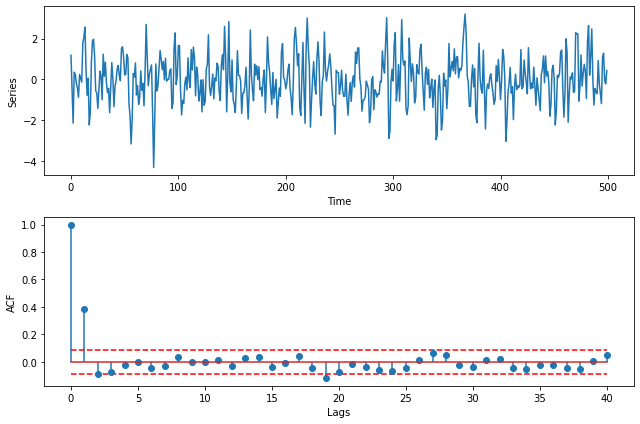

In [8]:
ma1_model = MAProcess([0.5])
ma1_series = ma1_model.generate(500)
ma1_acf = acf(ma1_series, nlags = 40, fft = True)
plot_acf(ma1_series)

In [11]:
ma1_sample_mean = ma1_series.mean()
ma1_sample_mean

0.048425935450177246

In [12]:
var_mean_estimator = ma1_series.var()/500
var_mean_estimator

0.0024393745290908373

In [13]:
var_corrected = var_mean_estimator*(1 + 2*np.array([1 - r/500 for r in range(1,40)])@ma1_acf[1:40])
var_corrected

0.011778514295033578

In [14]:
%%timeit
ar1_model = ARProcess([0.7])
ar1_series = ar1_model.generate(500, method = 1)
#ar1_acf = acf(ar1_series, fft = True, nlags = 40)
#plot_acf(ar1_series)

The slowest run took 6.38 times longer than the fastest. This could mean that an intermediate result is being cached.
45.8 ms ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
ar1_model = ARProcess([0.7])
ar1_series = ar1_model.generate(500, method = 2)
#ar1_acf = acf(ar1_series, fft = True, nlags = 40)
#plot_acf(ar1_series)

In [16]:
var_mean_estimator = ar1_series.var()/500
var_mean_estimator

0.003997938750635412

In [17]:
var_corrected = var_mean_estimator*(1 + 2*np.array([1 - r/500 for r in range(1,60)])@acf(ar1_series, nlags = 60,  fft = True)[1:60])
var_corrected

0.004863513691067119

In [18]:
(1-0.3)/(1+0.3)

0.5384615384615384

In [ ]:
(var_corrected/var_mean_estimator)**(-1)

In [ ]:
x = np.linspace(-1,1,100)[1:]
plt.plot(
    x,
    (1-x)/(1+x)
)
plt.show()

In [ ]:
500*(1-0.9)/(1+0.9)

## Section 4.2: Fitting an Autoregressive Process

In [ ]:
ar2_series = ARProcess([-0.4, 0.3]).generate(500)

In [ ]:
plot_acf(ar2_series)

In [ ]:
ar2_series.mean()

In [ ]:
r_1 = acf(ar2_series, nlags = 40, fft = True)[1]
r_1

In [ ]:
r_2 = acf(ar2_series,nlags = 40, fft = True)[2]
r_2

In [27]:
alpha_hat_1 = r_1*(1-r_2)/(1-r_1**2)
alpha_hat_1

-0.36148243588217094

In [28]:
alpha_hat_2 = (r_2-r_1**2)/(1-r_1**2)
alpha_hat_2

0.25831275566638195

In [29]:
(alpha_hat_1 - 1.96/np.sqrt(500), alpha_hat_1 + 1.96/np.sqrt(500))

(-0.4491363006001627, -0.2738285711641792)

In [30]:
(alpha_hat_2 - 1.96/np.sqrt(500), alpha_hat_2 + 1.96/np.sqrt(500))

(0.1706588909483902, 0.3459666203843737)

Estimating via a linear regression

In [31]:
import matplotlib.pyplot as plt

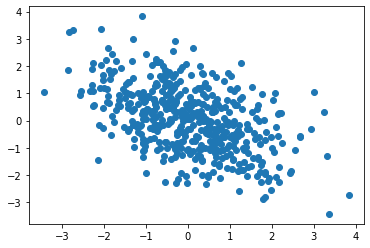

In [32]:
plt.scatter(ar2_series[1:-1], ar2_series[0:-2])
plt.show()

In [33]:
ar2_series_mean = ar2_series.mean()
ar2_series = ar2_series - ar2_series_mean
X = np.array([ar2_series[1:-1], ar2_series[0:-2]]).T
X = sm.add_constant(X)
ar2_linear_model = sm.OLS(ar2_series[2:].T, X)
ar2_results = ar2_linear_model.fit()
ar2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     101.2
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           1.44e-37
Time:                        17:38:00   Log-Likelihood:                -702.64
No. Observations:                 498   AIC:                             1411.
Df Residuals:                     495   BIC:                             1424.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.045      0.030      0.976      -0.086       0.089
x1            -0.3633      0.044     -8.336      0.000      -0.449      -0.278
x2             0.2600      0.044      5.966      0.000       0.174       0.346
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                2.409
Skew:                           0.161   Prob(JB):                        0.300
Kurtosis:                       2.891   Cond. No.                         1.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
sm.regression.yule_walker(ar2_series, order = 2)

(array([-0.36154111,  0.25967598]), 0.9910162669960686)

In [35]:
ar3_series = ARProcess([0.25, 0.5, -0.125]).generate(500)

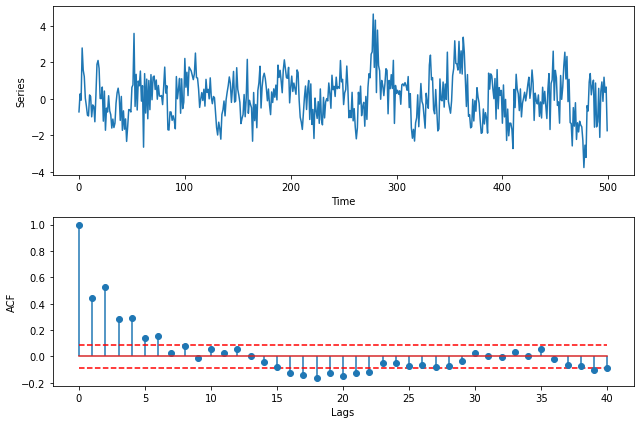

In [36]:
plot_acf(ar3_series)

In [37]:
ar3_series.mean()

0.10020048594026439

In [38]:
r_1 = acf(ar3_series, nlags = 40, fft = True)[1]
r_1

0.4415474798418242

In [39]:
r_2 = acf(ar3_series,nlags = 40, fft = True)[2]
r_2

0.5288285690412072

In [40]:
r_3 = acf(ar3_series,nlags = 40, fft = True)[2]
r_3

0.5288285690412072

In [41]:
series = ar3_series - ar3_series.mean()

In [42]:
X = np.array([series[2:-1], series[1:-2], series[0:-3]]).T

In [43]:
linear_model = sm.OLS(series[3:].T, X)

In [44]:
results = linear_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.337
Model:                            OLS   Adj. R-squared (uncentered):              0.333
Method:                 Least Squares   F-statistic:                              83.68
Date:                Tue, 21 Sep 2021   Prob (F-statistic):                    8.64e-44
Time:                        17:38:01   Log-Likelihood:                         -700.80
No. Observations:                 497   AIC:                                      1408.
Df Residuals:                     494   BIC:                                      1420.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2826      0.045      6.264      0.000       0.194       0.371
x2             0.4314      0.043     10.112      0.000       0.348       0.515
x3            -0.0575      0.045     -1.276      0.203      -0.146       0.031
==============================================================================
Omnibus:                        2.158   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                2.228
Skew:                           0.155   Prob(JB):                        0.328
Kurtosis:                       2.892   Cond. No.                         2.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
ar_mod = ARIMA(series, order = (3,0,0), trend = 'n')
ar_res = ar_mod.fit()
print(ar_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -704.176
Date:                Tue, 21 Sep 2021   AIC                           1416.352
Time:                        17:38:02   BIC                           1433.210
Sample:                             0   HQIC                          1422.967
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2817      0.043      6.490      0.000       0.197       0.367
ar.L2          0.4301      0.043     10.112      0.000       0.347       0.513
ar.L3         -0.0572      0.046     -1.256      0.2

In [46]:
sm.regression.yule_walker(ar3_series, order = 3)

(array([ 0.28078095,  0.43087602, -0.05458512]), 0.9882939041644381)

### Determining the order of an AR process

In [47]:
ar_series = ARProcess([1/4, 1/2, -1/8]).generate(500)

In [48]:
# Fitting with a regression with
Y = [
        np.array(
            [ar_series[i-j: -j] for j in range(1, i+1)]
        ).T
    for i in range(1,11)
]   
Y = list(map(sm.add_constant, Y))

In [49]:
models = [sm.OLS(ar_series[i+1:].T, Y[i]) for i in range(10)]

In [50]:
results = [model.fit() for model in models]

In [51]:
for result in results:
    print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     121.2
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           2.26e-25
Time:                        17:38:03   Log-Likelihood:                -750.71
No. Observations:                 499   AIC:                             1505.
Df Residuals:                     497   BIC:                             1514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0557      0.049      1.137      0.2

In [52]:
Y = [
        np.array(
            [ar_series[i-j: -j] for j in range(1, i+1)]
        ).T
    for i in range(1,11)
]
models = [sm.OLS(ar_series[i+1:].T, Y[i]) for i in range(10)]
results = [model.fit() for model in models]
for result in results:
    print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.200
Model:                            OLS   Adj. R-squared (uncentered):              0.198
Method:                 Least Squares   F-statistic:                              124.2
Date:                Tue, 21 Sep 2021   Prob (F-statistic):                    6.71e-26
Time:                        17:38:04   Log-Likelihood:                         -751.36
No. Observations:                 499   AIC:                                      1505.
Df Residuals:                     498   BIC:                                      1509.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [53]:
for i in range(1, 11):
    ar_mod = ARIMA(ar_series, order = (i,0,0), trend = 'n')
    ar_res = ar_mod.fit()
    print(ar_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -752.648
Date:                Tue, 21 Sep 2021   AIC                           1509.295
Time:                        17:38:04   BIC                           1517.725
Sample:                             0   HQIC                          1512.603
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4469      0.038     11.840      0.000       0.373       0.521
sigma2         1.1880      0.075     15.897      0.000       1.042       1.334
Ljung-Box (L1) (Q):                  17.77   Jarque-

In [54]:
for i in range(1, 11):
    ar_mod = ARIMA(ar_series, order = (i,0,0))
    ar_res = ar_mod.fit()
    print(ar_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -752.048
Date:                Tue, 21 Sep 2021   AIC                           1510.096
Time:                        17:38:08   BIC                           1522.740
Sample:                             0   HQIC                          1515.058
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0960      0.088      1.091      0.275      -0.076       0.268
ar.L1          0.4431      0.038     11.700      0.000       0.369       0.517
sigma2         1.1851      0.075     15.712      0.0

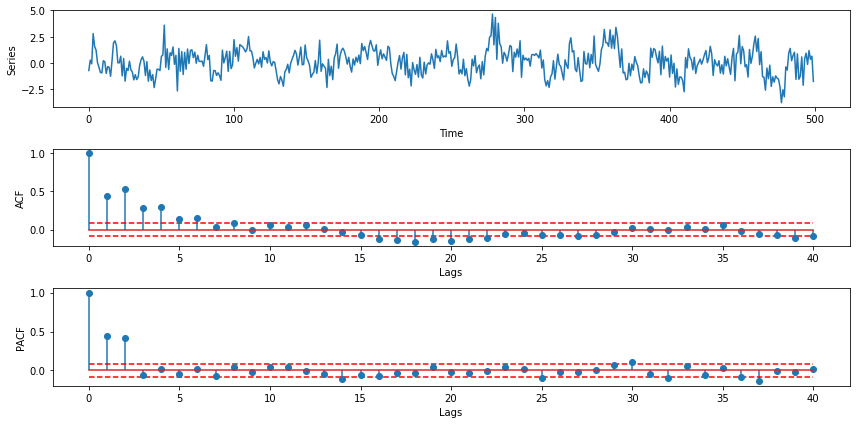

In [55]:
plot_acf(ar_series, plot_pacf = True)

### Fitting a Moving Average Process

In [56]:
sm.tsa.arma_generate_sample?

Signature:
sm.tsa.arma_generate_sample(
    ar,
    ma,
    nsample,
    scale=1,
    distrvs=None,
    axis=0,
    burnin=0,
)
Docstring:
Simulate data from an ARMA.

Parameters
----------
ar : array_like
    The coefficient for autoregressive lag polynomial, including zero lag.
ma : array_like
    The coefficient for moving-average lag polynomial, including zero lag.
nsample : int or tuple of ints
    If nsample is an integer, then this creates a 1d timeseries of
    length size. If nsample is a tuple, creates a len(nsample)
    dimensional time series where time is indexed along the input
    variable ``axis``. All series are unless ``distrvs`` generates
    dependent data.
scale : float
    The standard deviation of noise.
distrvs : function, random number generator
    A function that generates the random numbers, and takes ``size``
    as argument. The default is np.random.standard_normal.
axis : int
    See nsample for details.
burnin : int
    Number of observation at the begin

In [57]:
ar_series = sm.tsa.arma_generate_sample( ar = [0],ma = np.array([-0.5, 0.4]), nsample =500)
ar_series[0:20]

/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/signaltools.py:2010: RuntimeWarning: divide by zero encountered in true_divide
  b /= a[0]


array([ inf,  nan, -inf,  nan,  inf, -inf,  inf, -inf,  nan,  nan,  inf,
        nan, -inf,  inf, -inf,  inf, -inf,  inf, -inf,  inf])

In [58]:
sm.tsa.ArmaProcess?

Init signature: sm.tsa.ArmaProcess(ar=None, ma=None, nobs=100)
Docstring:     
Theoretical properties of an ARMA process for specified lag-polynomials.

Parameters
----------
ar : array_like
    Coefficient for autoregressive lag polynomial, including zero lag.
    Must be entered using the signs from the lag polynomial representation.
    See the notes for more information about the sign.
ma : array_like
    Coefficient for moving-average lag polynomial, including zero lag.
nobs : int, optional
    Length of simulated time series. Used, for example, if a sample is
    generated. See example.

Notes
-----
Both the AR and MA components must include the coefficient on the
zero-lag. In almost all cases these values should be 1. Further, due to
using the lag-polynomial representation, the AR parameters should
have the opposite sign of what one would write in the ARMA representation.
See the examples below.

The ARMA(p,q) process is described by

.. math::

    y_{t}=\phi_{1}y_{t-1}+\ldots+

In [59]:
ma_process = sm.tsa.ArmaProcess( ma = [-0.5, 0.4])

In [60]:
ma_process.isstationary

True

In [61]:
ma_process.isinvertible

True

In [62]:
ma_series = ma_process.generate_sample(500)

In [63]:
ARIMA(ma_series, order = (0,0,2), trend = 'n').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -375.111
Date:                Tue, 21 Sep 2021   AIC                            756.221
Time:                        17:38:14   BIC                            768.865
Sample:                             0   HQIC                           761.183
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7401      0.045    -16.312      0.000      -0.829      -0.651
ma.L2         -0.0225      0.045     -0.497      0.620      -0.111       0.066
sigma2         0.2621      0.018     14.943      0.000       0.228       0.296
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.47
Prob(Q):                              0.97   Prob(JB):                         0.48
Heteroskedasticity (H):               1.09   Skew:                            -0.07
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fitting an ARMA process

In [64]:
ar = np.array([1.0, -0.4, 0.3])
ma = np.array([1.0, -0.6, 0.5])
arma_model = sm.tsa.ArmaProcess(ar, ma)

In [65]:
arma_series = arma_model.generate_sample(500)

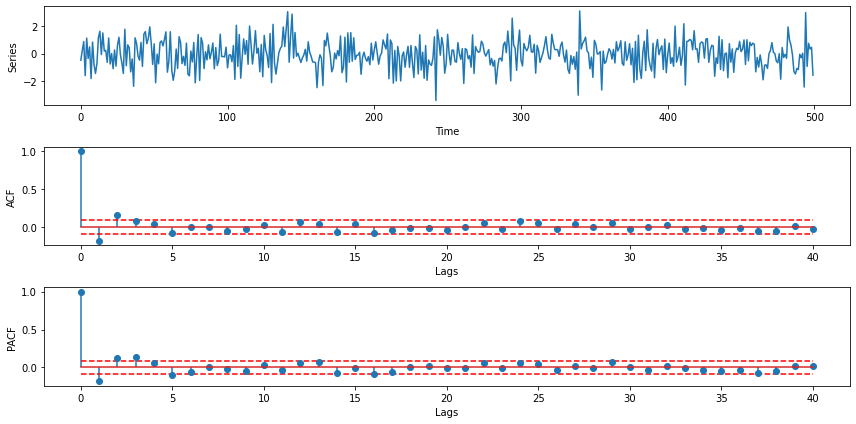

In [66]:
plot_acf(arma_series, True)

In [67]:
ARIMA(arma_series, order = (1,0,1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -707.801
Date:                Tue, 21 Sep 2021   AIC                           1423.602
Time:                        17:38:14   BIC                           1440.461
Sample:                             0   HQIC                          1430.218
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0429      0.039     -1.087      0.277      -0.120       0.034
ar.L1         -0.4879      0.195     -2.505      0.012      -0.870      -0.106
ma.L1          0.3082      0.214      1.441      0.149      -0.111       0.727
sigma2         0.9933      0.061     16.166      0.000       0.873       1.114
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.74   Prob(JB):                         0.60
Heteroskedasticity (H):               0.83   Skew:                            -0.09
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
ARIMA(arma_series, order = (2,0,2)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -698.127
Date:                Tue, 21 Sep 2021   AIC                           1408.254
Time:                        17:38:15   BIC                           1433.542
Sample:                             0   HQIC                          1418.177
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0432      0.048     -0.906      0.365      -0.137       0.050
ar.L1          0.3257      0.145      2.247      0.025       0.042       0.610
ar.L2         -0.2444      0.154     -1.589      0.112      -0.546       0.057
ma.L1         -0.5114      0.131     -3.892      0.000      -0.769      -0.254
ma.L2          0.4958      0.135      3.679      0.000       0.232       0.760
sigma2         0.9553      0.062     15.424      0.000       0.834       1.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.98   Prob(JB):                         0.59
Heteroskedasticity (H):               0.83   Skew:                            -0.11
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
ARIMA(arma_series, order = (3,0,3)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -697.852
Date:                Tue, 21 Sep 2021   AIC                           1411.704
Time:                        17:38:18   BIC                           1445.421
Sample:                             0   HQIC                          1424.934
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0432      0.047     -0.918      0.358      -0.135       0.049
ar.L1         -0.4807      0.494     -0.973      0.331      -1.449       0.488
ar.L2         -0.0330      0.231     -0.143      0.887      -0.486       0.420
ar.L3         -0.2717      0.171     -1.589      0.112      -0.607       0.064
ma.L1          0.2926      0.493      0.594      0.553      -0.674       1.259
ma.L2          0.1377      0.275      0.501      0.617      -0.401       0.677
ma.L3          0.4474      0.244      1.835      0.066      -0.030       0.925
sigma2         0.9542      0.062     15.373      0.000       0.833       1.076
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.90   Prob(JB):                         0.66
Heteroskedasticity (H):               0.82   Skew:                            -0.10
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
ARIMA(arma_series, order = (2,0,2), trend = 'n').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -698.550
Date:                Tue, 21 Sep 2021   AIC                           1407.100
Time:                        17:38:19   BIC                           1428.173
Sample:                             0   HQIC                          1415.369
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3331      0.145      2.302      0.021       0.049       0.617
ar.L2         -0.2364      0.155     -1.522      0.128      -0.541       0.068
ma.L1         -0.5175      0.131     -3.957      0.000      -0.774      -0.261
ma.L2          0.4907      0.136      3.598      0.000       0.223       0.758
sigma2         0.9569      0.061     15.598      0.000       0.837       1.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.07
Prob(Q):                              1.00   Prob(JB):                         0.58
Heteroskedasticity (H):               0.84   Skew:                            -0.11
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model Identification Tools

In [71]:
sm.tsa.ArmaProcess(ar = np.array([1, -1/4, -1/2, 1/8]), 
                   ma = np.array([1])).isstationary

True

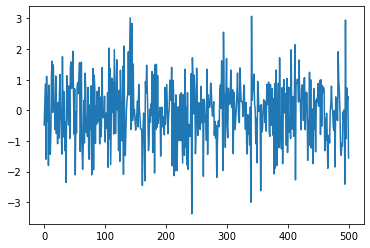

In [72]:
plt.plot(arma_series)
plt.show()

In [73]:
import pandas as pd

In [74]:
aic_df = pd.DataFrame(np.zeros((6,6)), dtype = float)

for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue
        
        # Estimate the model 
        try:
            mod = sm.tsa.statespace.SARIMAX(arma_series, 
                                        order = (p,0,q), 
                                        enforce_invertibility = False)
            res = mod.fit(disp = False)
            aic_df.iloc[p,q] = res.aic  
        except:
            aic_df.iloc[p,q] = np.nan
            
aic_df 

/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgomes/opt/anac

,0,1,2,3,4,5
0,0.000000,1428.696239,1410.585499,1405.685757,1407.607527,1408.076724
1,1424.615850,1422.796476,1406.862187,1407.646482,1408.658916,1409.825408
2,1417.781734,1413.304923,1407.100283,1409.058780,1405.715400,1405.765446
3,1410.237090,1411.538093,1409.035180,1410.583666,1405.860620,1409.367407
4,1410.472480,1410.939081,1409.664220,1411.418967,1407.426757,1409.062153
5,1407.907295,1408.723948,1410.717401,1412.199765,1409.045097,1411.503364


In [75]:
aic_df = pd.DataFrame(np.zeros((6,6)), dtype = float)

for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue
        
        # Estimate the model 
        try:
            mod = sm.tsa.statespace.SARIMAX(arma_series, 
                                        order = (p,0,q), 
                                        enforce_invertibility = True)
            res = mod.fit(disp = False)
            aic_df.iloc[p,q] = res.aic  
        except:
            aic_df.iloc[p,q] = np.nan
            
aic_df 

/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgomes

,0,1,2,3,4,5
0,0.000000,1428.696239,1410.585499,1405.685757,1407.607527,1408.076723
1,1424.615850,1422.796476,1406.862187,1407.646482,1408.658913,1409.825407
2,1417.781734,1413.304908,1407.100283,1409.058782,1405.715399,1405.719882
3,1410.237090,1411.538093,1409.035163,1410.583666,1405.860789,1409.351682
4,1410.472480,1410.939078,1409.915295,1411.418967,1408.002501,1409.152722
5,1407.907295,1408.723947,1410.712848,1412.177472,1408.964453,1410.395379


## Testing for unit roots

Comparing a high alpha AR(1) process to a Random Walk:

In [76]:
n_samples = 252

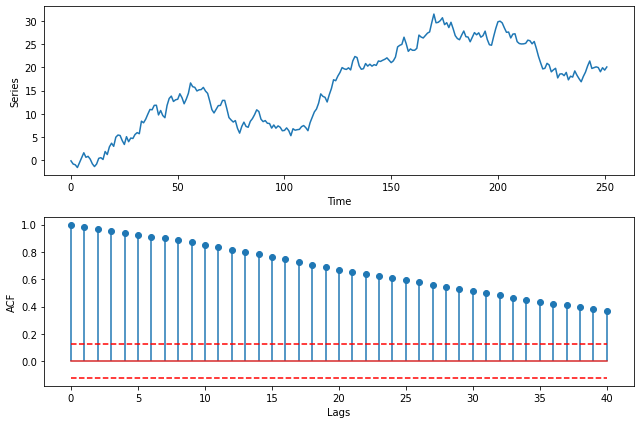

In [77]:
walk = RandomWalk()
walk_series = walk.generate(n_samples)
plot_acf(walk_series)

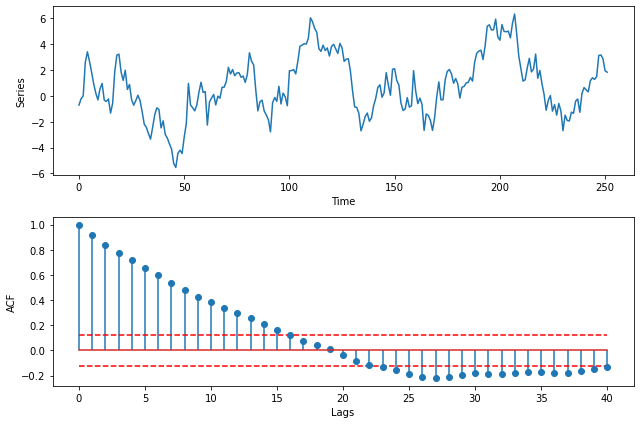

In [78]:
ar1_series = ARProcess([0.95]).generate(n_samples)
plot_acf(ar1_series)

In [79]:
model = sm.tsa.ArmaProcess(ar = [1,-0.95], ma = [1])

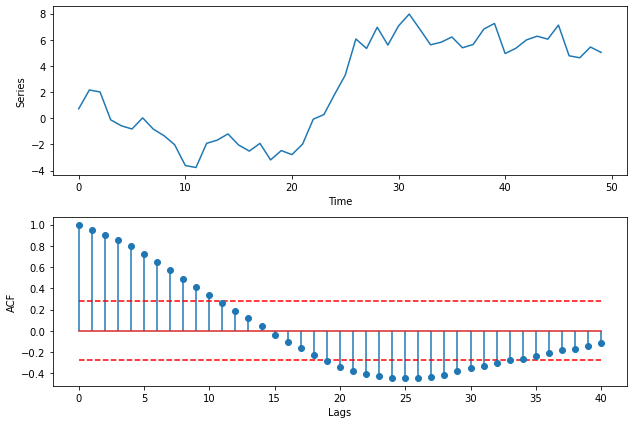

In [80]:
plot_acf(model.generate_sample(50))

Add a simulation of variances for RandomWalk and ARProcess over long runs.

In [81]:
help(sm.tsa.adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}.
    regression : {"c","ct","ctt","nc"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "nc" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
        values 0, 1, ..., maxlag.
    
        * If "AIC" (default)

In [82]:
sm.tsa.adfuller(walk_series)

(-1.8925838322069384,
 0.33555791279309244,
 1,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 672.3003857272633)

In [83]:
sm.tsa.adfuller(ar1_series)

(-3.2394157544906124,
 0.017813540633008794,
 0,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 624.7105440364526)

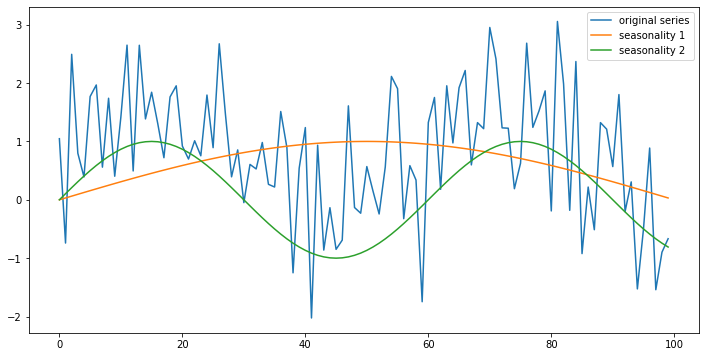

In [89]:
x = np.arange(100)
s_1 = np.sin(np.pi*x/100) 
s_2 = np.sin(np.pi*x/30)
s = s_1+ s_2 + np.random.normal( size = 100)
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(x, s, label = 'original series')
ax.plot(x,s_1, label = 'seasonality 1')
ax.plot(x,s_2, label = 'seasonality 2')
plt.legend()
plt.show()

In [90]:
help(sm.tsa.statespace.SARIMAX)

Help on class SARIMAX in module statsmodels.tsa.statespace.sarimax:

class SARIMAX(statsmodels.tsa.statespace.mlemodel.MLEModel)
 |  SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs)
 |  
 |  Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
 |  model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The observed time-series process :math:`y`
 |  exog : array_like, optional
 |      Array of exogenous regressors, shaped nobs x k.
 |  order : iterable or iterable of iterables, optional
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA p

In [91]:
aus_wine_sales = pd.read_csv('aus_wine_sales.csv', header = None)
aus_wine_sales

,0,1
0,Mar-1985,7006
1,Jun-1985,10516
2,Sep-1985,11089
3,Dec-1985,9637
4,Mar-1986,6448
...,...,...
113,Jun-2013,3696
114,Sep-2013,3894
115,Dec-2013,3571
116,Mar-2014,2837


In [92]:
pd.to_datetime(aus_wine_sales.iloc[:,0], infer_datetime_format=True)

0     1985-03-01
1     1985-06-01
2     1985-09-01
3     1985-12-01
4     1986-03-01
         ...    
113   2013-06-01
114   2013-09-01
115   2013-12-01
116   2014-03-01
117   2014-06-01
Name: 0, Length: 118, dtype: datetime64[ns]

In [93]:
aus_wine_sales.iloc[:,0] = pd.to_datetime(aus_wine_sales.iloc[:,0], 
                                          infer_datetime_format=True)
aus_wine_sales.set_index(aus_wine_sales.iloc[:,0], inplace = True)
aus_wine_sales

,0,1
0,,
1985-03-01,1985-03-01,7006
1985-06-01,1985-06-01,10516
1985-09-01,1985-09-01,11089
1985-12-01,1985-12-01,9637
1986-03-01,1986-03-01,6448
...,...,...
2013-06-01,2013-06-01,3696
2013-09-01,2013-09-01,3894
2013-12-01,2013-12-01,3571


In [94]:
aus_wine_sales.drop(columns = [0], inplace = True)
aus_wine_sales 

,1
0,
1985-03-01,7006
1985-06-01,10516
1985-09-01,11089
1985-12-01,9637
1986-03-01,6448
...,...
2013-06-01,3696
2013-09-01,3894
2013-12-01,3571


In [95]:
y = aus_wine_sales.diff(4)[4:]
y

,1
0,
1986-03-01,-558.0
1986-06-01,-874.0
1986-09-01,504.0
1986-12-01,-211.0
1987-03-01,-622.0
...,...
2013-06-01,-539.0
2013-09-01,-344.0
2013-12-01,-387.0


In [101]:
res = sm.tsa.statespace.SARIMAX(
    y, 
    order = (3,0,4)).fit()

    

/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19062D+00    |proj g|=  4.67875D-01

At iterate    5    f=  7.13965D+00    |proj g|=  3.04714D-02

At iterate   10    f=  7.11675D+00    |proj g|=  3.20117D-02

At iterate   15    f=  7.11133D+00    |proj g|=  2.20155D-02

At iterate   20    f=  7.10958D+00    |proj g|=  1.82086D-02

At iterate   25    f=  7.10909D+00    |proj g|=  1.58218D-02

At iterate   30    f=  7.10759D+00    |proj g|=  1.44064D-02

At iterate   35    f=  7.10691D+00    |proj g|=  1.08548D-02

At iterate   40    f=  7.10685D+00    |proj g|=  2.92272D-03

At iterate   45    f=  7.10685D+00    |proj g|=  1.27302D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [102]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      1   No. Observations:                  114
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -810.181
Date:                Tue, 21 Sep 2021   AIC                           1636.361
Time:                        18:32:41   BIC                           1658.251
Sample:                    03-01-1986   HQIC                          1645.245
                         - 06-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0244      0.064     -0.381      0.703      -0.150       0.101
ar.L2          0.1560      0.060      2.606      0.009       0.039       0.273
ar.L3          0.8653      0.058     14.856      0.000       0.751       0.979
ma.L1          0.1998      0.090      2.231      0.026       0.024       0.375
ma.L2          0.0400      0.085      0.472      0.637      -0.126       0.206
ma.L3         -0.7300      0.090     -8.143      0.000      -0.906      -0.554
ma.L4         -0.4040      0.093     -4.325      0.000      -0.587      -0.221
sigma2      8.284e+04    1.4e+04      5.918      0.000    5.54e+04     1.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.95   Prob(JB):                         0.29
Heteroskedasticity (H):               0.54   Skew:                            -0.16
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
res = sm.tsa.statespace.SARIMAX(
    y, 
    order = (2,0,3)).fit()

/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31088D+00    |proj g|=  1.57616D-01

At iterate    5    f=  7.26651D+00    |proj g|=  5.80061D-02

At iterate   10    f=  7.23213D+00    |proj g|=  9.79363D-03

At iterate   15    f=  7.22890D+00    |proj g|=  6.06897D-03

At iterate   20    f=  7.22367D+00    |proj g|=  1.49524D-02

At iterate   25    f=  7.21991D+00    |proj g|=  5.10381D-03

At iterate   30    f=  7.21613D+00    |proj g|=  1.36681D-03

At iterate   35    f=  7.21598D+00    |proj g|=  2.14546D-04

At iterate   40    f=  7.21594D+00    |proj g|=  2.53893D-03

At iterate   45    f=  7.21507D+00    |proj g|=  2.23854D-03


/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.21487D+00    |proj g|=  7.62756D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   7.628D-05   7.215D+00
  F =   7.2148690913232940     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [104]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      1   No. Observations:                  114
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -822.495
Date:                Tue, 21 Sep 2021   AIC                           1656.990
Time:                        18:33:35   BIC                           1673.407
Sample:                    03-01-1986   HQIC                          1663.653
                         - 06-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2793      0.218      1.280      0.201      -0.149       0.707
ar.L2          0.7185      0.219      3.284      0.001       0.290       1.147
ma.L1         -0.1571      0.248     -0.634      0.526      -0.643       0.328
ma.L2         -0.8517      0.144     -5.921      0.000      -1.134      -0.570
ma.L3          0.0697      0.146      0.478      0.633      -0.216       0.356
sigma2      1.061e+05   1.55e+04      6.835      0.000    7.57e+04    1.37e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.87   Prob(JB):                         0.73
Heteroskedasticity (H):               0.66   Skew:                            -0.07
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
aic_df = pd.DataFrame(np.zeros((6,6)), dtype = float)

for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue
        
        # Estimate the model 
        try:
            mod = sm.tsa.statespace.SARIMAX(y.values, 
                                        order = (p,0,q),  
                                        trend = 'c')
            res = mod.fit(disp = False)
            aic_df.iloc[p,q] = res.aic  
        except:
            aic_df.iloc[p,q] = np.nan
            
aic_df 

/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgomes/opt/anaconda3/lib/python3.8/site-p

,0,1,2,3,4,5
0,0.000000,1652.503658,1653.521003,1650.854037,1637.755097,1637.869637
1,1652.496240,1654.270208,1655.125092,1645.545794,1639.068207,1639.859598
2,1654.216823,1655.868229,1653.706705,1633.401783,1641.256551,1641.052225
3,1652.029040,1645.695488,1637.546878,1637.439733,1634.391047,1636.722370
4,1638.444860,1639.780579,1641.593300,1634.823860,1636.107427,1641.991362
5,1638.383547,1639.650889,1635.868783,1635.732222,1634.970538,1639.453643


In [99]:
aic_df.min()

0       0.000000
1    1643.139028
2    1644.963208
3    1638.013926
4    1636.361116
5    1639.620550
dtype: float64

In [100]:
ARIMA(y, order = (3,0,4)).fit().summary()

/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
/Users/mgomes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      1   No. Observations:                  114
Model:                 ARIMA(3, 0, 4)   Log Likelihood                -808.294
Date:                Tue, 21 Sep 2021   AIC                           1634.589
Time:                        18:29:44   BIC                           1659.215
Sample:                    03-01-1986   HQIC                          1644.583
                         - 06-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -211.8674     35.310     -6.000      0.000    -281.074    -142.660
ar.L1         -0.2486      1.847     -0.135      0.893      -3.868       3.371
ar.L2         -0.0816      1.903     -0.043      0.966      -3.812       3.649
ar.L3          0.6693      1.627      0.412      0.681      -2.519       3.857
ma.L1          0.4009      1.836      0.218      0.827      -3.197       3.999
ma.L2          0.2686      2.139      0.126      0.900      -3.924       4.461
ma.L3         -0.5153      2.171     -0.237      0.812      -4.770       3.739
ma.L4         -0.3392      0.739     -0.459      0.646      -1.787       1.109
sigma2      7.783e+04    1.2e+04      6.498      0.000    5.44e+04    1.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.02
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               0.55   Skew:                            -0.20
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='0'>

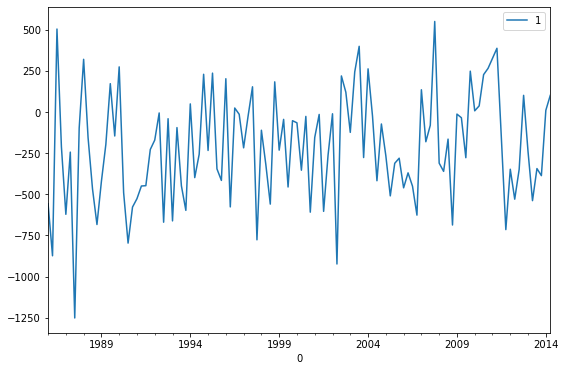

In [106]:
y.plot(figsize = (9,6))

In [116]:
ARIMA(y.values, order = (2,0,3), trend = 'c').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -808.206
Date:                Tue, 21 Sep 2021   AIC                           1630.411
Time:                        18:49:15   BIC                           1649.565
Sample:                             0   HQIC                          1638.184
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -212.2758     36.589     -5.802      0.000    -283.989    -140.563
ar.L1         -1.0225      0.062    -16.419      0.000      -1.145      -0.900
ar.L2         -0.8662      0.057    -15.303      0.000      -0.977      -0.755
ma.L1          1.1775      0.088     13.378      0.000       1.005       1.350
ma.L2          1.1856      0.090     13.246      0.000       1.010       1.361
ma.L3          0.4211      0.090      4.667      0.000       0.244       0.598
sigma2      8.283e+04   1.34e+04      6.193      0.000    5.66e+04    1.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.11
Prob(Q):                              0.98   Prob(JB):                         0.35
Heteroskedasticity (H):               0.54   Skew:                            -0.20
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""